In [1]:
from os import getcwd, path, listdir, path
from pathlib import Path
from matplotlib.pyplot import axis, imshow, show, figure, title, subplot, plot, legend
from keras import layers, losses, optimizers, Sequential, backend, utils, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import data
from numpy import argmax
from gc import collect

# Constants

In [3]:
IMG_SIZE = 224
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.3
SEED = 123
ALL_PATH = path.join(Path(getcwd()).parents[0], 'dataset', 'all_data')
CATEGORIES = sorted([ dir_name for dir_name in listdir(ALL_PATH) if path.isdir(path.join(ALL_PATH, dir_name)) ])

# Import dataset

In [4]:
train_ds, valid_ds = utils.image_dataset_from_directory(ALL_PATH,
                                                        #color_mode='grayscale',
                                                        subset='both',
                                                        label_mode='categorical',
                                                        validation_split=VALIDATION_SPLIT,
                                                        seed=SEED,
                                                        image_size=(IMG_SIZE, IMG_SIZE),
                                                        batch_size=BATCH_SIZE,
                                                        #shuffle=True
                                                        )

count = data.experimental.cardinality(valid_ds)
test_ds = valid_ds.take(count // 5)
valid_ds = valid_ds.skip(count // 5)

print('Number of validation batches: %d' % data.experimental.cardinality(valid_ds))
print('Number of test batches: %d' % data.experimental.cardinality(test_ds))

Found 2197 files belonging to 5 classes.
Using 1538 files for training.
Using 659 files for validation.
Number of validation batches: 9
Number of test batches: 2


# Dataset visualization

25 total batches
(64, 224, 224, 3) (64, 5)


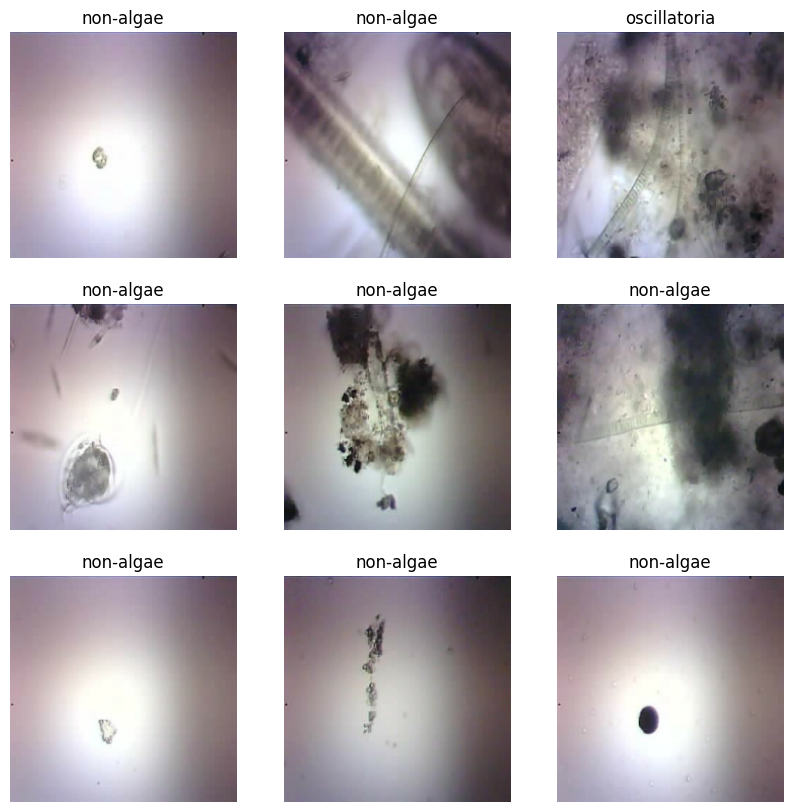

In [5]:
print(len(train_ds), 'total batches')

figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    print(images.shape, labels.shape)
    for i in range(9):
        ax = subplot(3, 3, i + 1)
        imshow(images[i].numpy().astype("uint8"))
        title(CATEGORIES[labels[i].numpy().argmax()])
        axis("off")

In [6]:
def reset_keras(model, has_model: bool = True):
    backend.clear_session()
    if has_model: del model
    collect()

In [7]:
model_shape = images.shape[1:]

# Build and compile model

In [8]:
reset_keras(None, False)

# Prefetching samples in GPU memory helps maximize GPU utilization
train_ds = train_ds.shuffle(1000).prefetch(data.AUTOTUNE).cache()
valid_ds = valid_ds.prefetch(data.AUTOTUNE).cache()
test_ds = test_ds.prefetch(data.AUTOTUNE).cache()

def build_model():
  model = Sequential([
    layers.Input(shape=model_shape),# batch_size=images.shape[0]),
    layers.RandomFlip('horizontal_and_vertical', input_shape=model_shape),
    layers.Rescaling(1./255),

    layers.Conv2D(filters=64, kernel_size=5, strides=2, padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=3, strides=2),
    layers.BatchNormalization(momentum=0.9),

    layers.Conv2D(filters=64, kernel_size=5, strides=2, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=3, strides=1),
    layers.BatchNormalization(momentum=0.9),

    layers.Conv2D(filters=128, kernel_size=5, padding='same', strides=2, activation='relu'),
    layers.MaxPooling2D(pool_size=3, strides=1),
    layers.BatchNormalization(momentum=0.9),

    layers.Dropout(0.1),

    layers.Flatten(),

    layers.Dense(1024, activation='relu'),# input_shape=(prod(image_batch.shape[1:]),)),
    layers.BatchNormalization(momentum=0.9),

    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(momentum=0.9),
      
    layers.Dense(len(CATEGORIES), activation='softmax')
  ])

  return model

In [9]:
def compile(model) -> None:
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate=1e-5),
              loss=losses.CategoricalCrossentropy(from_logits=False),
              metrics=[metrics.CategoricalAccuracy("accuracy")])

# Train model

In [10]:
EPOCHS = 25
VERBOSE = 1
MONITOR = 'val_loss'
MODE = 'min'

EARLY = EarlyStopping(monitor=MONITOR,
                      patience=20,
                      verbose=VERBOSE,
                      mode=MODE,
                      restore_best_weights=True
                      )

def checkpoint(name: str) -> ModelCheckpoint:
    return ModelCheckpoint(name,
                           monitor=MONITOR,
                           verbose=VERBOSE,
                           save_best_only=True,
                           mode=MODE
                           )

def fit(model, filename: str = "../model_weights/model.keras"):
    return model.fit(train_ds,
                     validation_data=valid_ds,
                     epochs=EPOCHS,
                     verbose=VERBOSE,
                     shuffle=True,
                     callbacks=[checkpoint(filename),EARLY]
                     )

In [11]:
model = build_model()
compile(model)

history = fit(model)
model.summary()

Epoch 1/25
25/25 [==============================] - ETA: 0s - loss: 1.8707 - accuracy: 0.2893
Epoch 1: val_loss improved from inf to 2.50175, saving model to model.keras
25/25 [==============================] - 6s 208ms/step - loss: 1.8707 - accuracy: 0.2893 - val_loss: 2.5017 - val_accuracy: 0.4313
Epoch 2/25
25/25 [==============================] - ETA: 0s - loss: 1.5707 - accuracy: 0.3914
Epoch 2: val_loss improved from 2.50175 to 2.06443, saving model to model.keras
25/25 [==============================] - 5s 201ms/step - loss: 1.5707 - accuracy: 0.3914 - val_loss: 2.0644 - val_accuracy: 0.3729
Epoch 3/25
25/25 [==============================] - ETA: 0s - loss: 1.4471 - accuracy: 0.4434
Epoch 3: val_loss improved from 2.06443 to 1.39737, saving model to model.keras
25/25 [==============================] - 5s 205ms/step - loss: 1.4471 - accuracy: 0.4434 - val_loss: 1.3974 - val_accuracy: 0.4482
Epoch 4/25
25/25 [==============================] - ETA: 0s - loss: 1.3431 - accuracy: 0.

# Evaluate accuracy

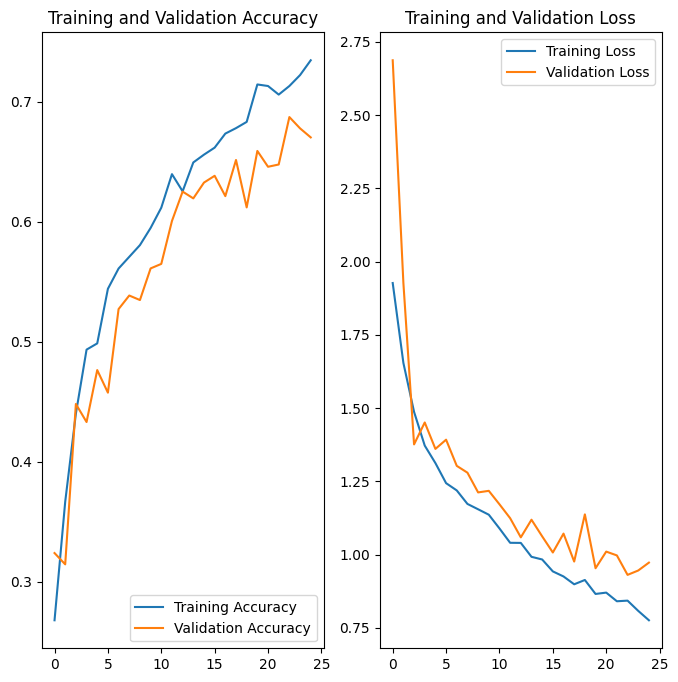

In [11]:
acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
figure(figsize=(8, 8))
subplot(1, 2, 1)
plot(acc, label='Training Accuracy')
plot(val_acc, label='Validation Accuracy')
legend(loc='lower right')
title('Training and Validation Accuracy')

loss, val_loss = history.history['loss'], history.history['val_loss']
subplot(1, 2, 2)
plot(loss, label='Training Loss')
plot(val_loss, label='Validation Loss')
legend(loc='upper right')
title('Training and Validation Loss')
show()

# Testing and predicting

2/2 [==============================] - 0s 64ms/step - loss: 1.0028 - accuracy: 0.6797
77.78% of predictions are correct


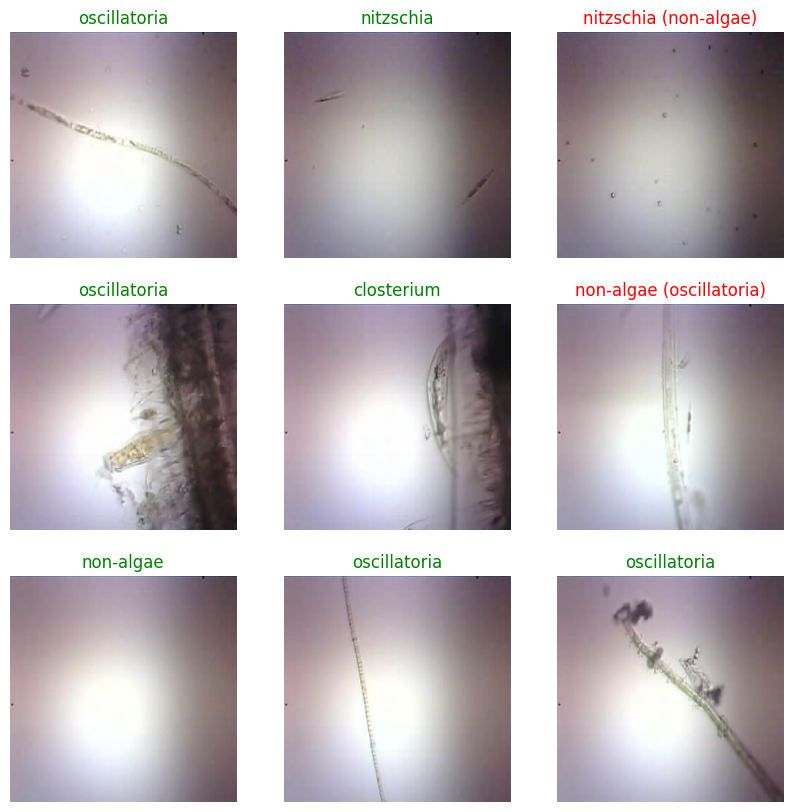

In [12]:
model.evaluate(test_ds, verbose = 1) # type: ignore
probability_model = Sequential([model, layers.Softmax()])
prediction = probability_model.predict(test_ds, verbose = 0) # type: ignore
plot_title = ""
counter = 0
START = 27
STOP = 45
STEPS = 2

figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        predict = CATEGORIES[argmax(prediction[i])]
        correct = CATEGORIES[argmax(labels[i].numpy())]
        img = images[i].numpy().astype("uint8")

        ax = subplot(3, 3, (i) + 1)
        axis("off")
        imshow(img)

        if predict == correct:
            title(predict, fontdict={'color': 'green'})
            counter += 1
        else: title(f"{predict} ({correct})", fontdict={'color': 'red'})

print(f"{counter / 9 * 100:.2f}% of predictions are correct")

In [13]:
from matplotlib.pyplot import grid, xticks, yticks, imshow, xlabel, bar, cm, ylim
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  grid(False)
  xticks([])
  yticks([])

  imshow(img, cmap=cm._colormaps.get_cmap('binary'))

  predicted_label = argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  xlabel("{} {:2.0f}% ({})".format(CATEGORIES[predicted_label],
                                100*max(predictions_array),
                                CATEGORIES[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  grid(False)
  xticks(range(10))
  yticks([])
  thisplot = bar(range(10), predictions_array, color="#777777")
  ylim([0, 1])
  predicted_label = argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [14]:
# i = 0
# figure(figsize=(6,3))
# subplot(1,2,1)

# plot_image(i, CATEGORIES[argmax(prediction[i])], CATEGORIES[argmax(labels[i].numpy())], images[i].numpy().astype("uint8"))
# subplot(1,2,2)
# plot_value_array(i, CATEGORIES[argmax(prediction[i])],  CATEGORIES[argmax(labels[i].numpy())])
# show()

In [15]:
reset_keras(model)